## Importing Libraries

In [80]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import gmean
from sklearn.decomposition import PCA
#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#Local module
import pathway_modules as pathw

## Reading all the data

#### Reading sample info and genes IDs
* Editing columns for better call
* Filtering samples in sample variable
* Read the ensemble IDs file

In [81]:
sample_info = pd.read_csv("./data_external/melanoma_data/sample.csv")
sample_info.columns = ['File_Name', 'Case_ID','Sample_ID','Sample_Type']

sample = sample_info.loc[~
    (sample_info.Sample_Type == 'Additional Metastatic')
    ]

ensembl_ids = pd.read_csv("./data_generated/ensemble.txt",
                          sep='\t',header=None).iloc[:,0]

print(sample.Sample_Type.value_counts())
print('Genes:',ensembl_ids.shape[0])

Metastatic             367
Primary Tumor          103
Solid Tissue Normal      1
Name: Sample_Type, dtype: int64
Genes: 60483


#### Read the expression data sample files
Create a list with all values 

In [82]:
# create empty list to store expression data from files
data_list = []
# filling the Array files data in datos21 folder
for file in sample.File_Name:
    data_read = pd.read_csv(f'./data_external/melanoma_data/datos21/{file}', sep='\t', 
                                  header=None, usecols=[1])
    data_list.append(data_read.values)

# transform in a numpy array
data_stored = np.concatenate(data_list, axis=1).T

### Transformations
- Sum 0.1 to all values 
- Get the mean values of samples

In [83]:
# sum 0.1 to avoid 0 divisions
data_stored += 0.1
# The normal sample
normalSKCM = data_stored[sample.Sample_Type == 'Solid Tissue Normal']
# Geometric mean of the primary tumor samples
tumorSKCM = gmean(data_stored[sample.Sample_Type == 'Primary Tumor'])
# Geometric mean metastatic samples
metSKCM = gmean(data_stored[sample.Sample_Type == 'Metastatic'])

### Diferenttial expression with normal and primary as references
$$e_{tumor}/e_{normal}, e_{metastatic}/e_{tumor}$$
and then create a dataframe with the logFC of differential expressed values
$$Log2(e/e_{ref})$$

In [90]:
# Diff Expression
et_en = (tumorSKCM/normalSKCM.T[:,0])
em_et = (metSKCM/tumorSKCM)
# Create DataFrame
data = np.concatenate((et_en.reshape(-1, 1),em_et.reshape(-1, 1)), 
                      axis=1)
data = pd.DataFrame(data=np.log2(data),index=ensembl_ids,
                    columns=['NORMALtoTUMOR','TUMORtoMETASTATIC'])

print(et_en.shape, em_et.shape)
print(data.shape)

(60483,) (60483,)
(60483, 2)


## Export means and references values

#### Export to txt files

In [85]:
np.savetxt('./data_generated/melanoma/normalSKCM.txt', normalSKCM)
np.savetxt('./data_generated/melanoma/primarySKCM.txt', tumorSKCM)
np.savetxt('./data_generated/melanoma/metSKCM.txt', metSKCM)

## Pathways

#### Load All 2233 pathways 
Get the data and filter it

In [86]:
all_pathways = pathw.pathway_query(
    "./data_external/data_pathways/All_pathways.xlsx",
    ensembl_ids)

#### Get pathway expression matrix for all 2233 pathw

In [87]:
# Non repeated pathway names
pathway_names = pd.unique(all_pathways.Pathways)

# Pathway expression matrix
P_matrix = pathw.pathway_expression(
    expression_matrix=data,
    pathway_data=all_pathways,
    pathway_names=pathway_names)

print(P_matrix.shape)

(2233, 2)


### Top 28 pathways
1 - Load data

In [98]:
top_pathways = pathw.pathway_query(
    "./data_external/data_pathways/Top28_pathways.xls",
    ensembl_ids)

2 - Get the expression matrix for 28 top pathways

In [89]:
# Non repeated pathway names
top_pathway_names = pd.unique(top_pathways.Pathways)

# Pathway expression matrix
P28_matrix = pathw.pathway_expression(
    expression_matrix=data,
    pathway_data=top_pathways,
    pathway_names=top_pathway_names)

print(P28_matrix.shape)

(28, 2)


In [114]:
T28path_genes = pd.unique(top_pathways.Ensemble)
#tumorSKCM[T28path_genes]
T28path_genes

array(['ENSG00000005893', 'ENSG00000023287', 'ENSG00000025039', ...,
       'ENSG00000261701', 'ENSG00000265107', 'ENSG00000274611'],
      dtype=object)

## Graphics

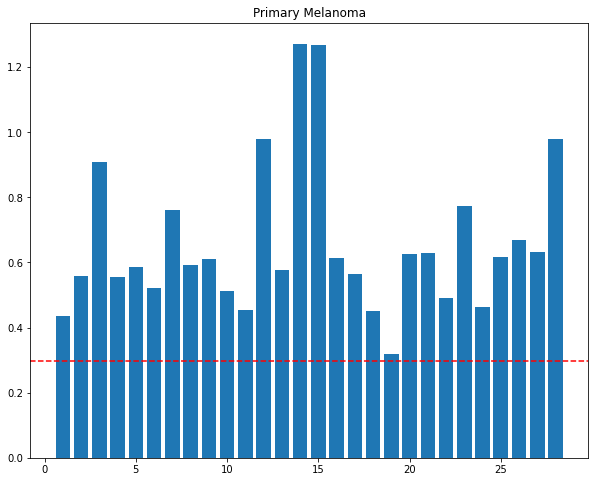

In [107]:
plt.figure(figsize=(10,8))
plt.title('Primary Melanoma')

plt.bar(np.arange(1,29),P28_matrix.NORMALtoTUMOR)
plt.axhline(abs(data.NORMALtoTUMOR.loc[T28path_genes].mean()),color='red',linestyle='dashed')

<BarContainer object of 28 artists>

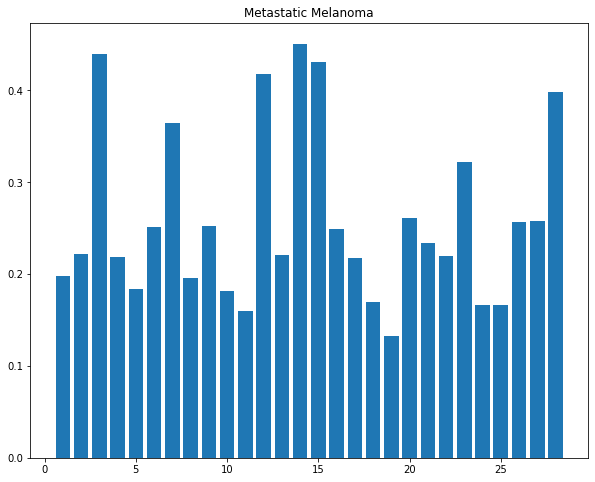

In [93]:
plt.figure(figsize=(10,8))
plt.title('Metastatic Melanoma')
plt.bar(np.arange(1,29),P28_matrix.TUMORtoMETASTATIC)